# Street canyon example in Radiosity

This example shows the process of simulating a geometry such as a street canyon while applying different properties to the wall boundaries.


First, import all of our dependencies.

In [1]:
import numpy as np
import pyfar as pf
import sofar as sf
import spharpy as sph
import sparrowpy as sp
import matplotlib.pyplot as plt
import os

%matplotlib inline

Set general parameters for the simulation.

In [2]:
patch_size = 4  # Small values increase computation time by a lot
etc_duration = 1
etc_time_resolution = 1 / 100
max_reflection_order = 50  # FIXME check lowest num for good result and speedup
speed_of_sound = 343.2

Define the street canyon scene.


Dimensions for boundaries can be set as in **Sound propagation in street canyons: Comparison between
diffusely and geometrically reflecting boundaries** by Kang published in 2000. Paper: https://doi.org/10.1121/1.428580

In [3]:
# Canyon boundary dimensions in meters
# (Kang used e.g. 120x20x18 but this takes longer to compute)
length = 35  # X
width = 10  # Y
height = 4  # Z


# Specify the source and receiver position.
# (For example, set the same position for source and receiver)
source = pf.Coordinates(30, 6, 1)
receiver = pf.Coordinates(30, 6, 1)


# Create geometry for the two facades and the ground
boundaries = [
    sp.geometry.Polygon(
        np.array(
            [  # corner points
                [0, 0, 0],
                [0, 0, height],
                [length, 0, 0],
                [length, 0, height],
            ],
        ),
        np.array([1, 0, 0]),  # up vector
        np.array([0, 1, 0]),  # normal vector
    ),
    sp.geometry.Polygon(
        np.array(
            [
                [0, 0, 0],
                [0, width, 0],
                [length, 0, 0],
                [length, width, 0],
            ],
        ),
        np.array([1, 0, 0]),
        np.array([0, 0, 1]),
    ),
    sp.geometry.Polygon(
        np.array(
            [
                [0, width, 0],
                [length, width, 0],
                [0, width, height],
                [length, width, height],
            ],
        ),
        np.array([1, 0, 0]),
        np.array([0, -1, 0]),
    ),
]

Create the instances of ``DirectionalRadiosityFast`` from the previously defined boundaries and the patch size.

In [4]:
radiosity_diffuse = sp.DirectionalRadiosityFast.from_polygon(
    boundaries,
    patch_size,
)
radiosity_retroreflection = sp.DirectionalRadiosityFast.from_polygon(
    boundaries,
    patch_size,
)

/home/ubunti/HiWi/sparrowpy/sparrowpy/geometry.py:379: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums


A simple setup for purely diffuse scattering boundaries.

In [5]:
# just define a simple point for the BRDF sources and receivers
brdf_sources = pf.Coordinates(0, 0, 1, weights=1)
brdf_receivers = pf.Coordinates(0, 0, 1, weights=1)

# set the coefficient values per frequency band
frequencies = np.array([2000])
scattering_coefficient = 1  # totally diffuse
scattering_data = pf.FrequencyData(
    [scattering_coefficient],
    frequencies,
)
absorption_coefficient = 0.1
absorption_data = pf.FrequencyData(
    [absorption_coefficient],
    frequencies,
)

# use internal function to construct the BRDF data
brdf_diffuse = sp.brdf.create_from_scattering(
    brdf_sources,
    brdf_receivers,
    scattering_data,
    absorption_data,
)

# set the created scattering data in the radiosity instance
radiosity_diffuse.set_wall_brdf(
    np.arange(len(boundaries)).tolist(),
    brdf_diffuse,
    brdf_sources,
    brdf_receivers,
)

For the retroreflection, BRDF data in the form of a ``.sofa`` file is used.

The BRDF data is visualized below.

SOFA file contained custom entries
----------------------------------
SourceWeights, ReceiverWeights

The BRDF data contains 144 points.
The BRDF data contains 0 datapoints with imag values.


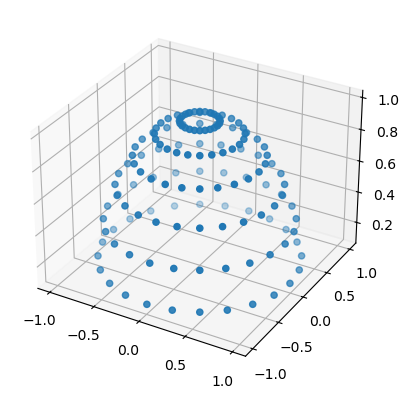

BRDF from source pos: -0.16516830385398643 / 0.6164165017830521 / 0.7699026741943047
BRDF maximum reflective coordinates: 0.45124819792906545 / -0.4512481979290657 / 0.7699026741943047 




/home/ubunti/miniconda3/envs/spapy/lib/python3.11/site-packages/spharpy/_deprecation.py:10: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  if coordinates.sh_order is None:
/home/ubunti/miniconda3/envs/spapy/lib/python3.11/site-packages/spharpy/samplings/coordinates.py:298: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of .cartesian'
  cartesian = coords.get_cart(convention='right', unit='met').T


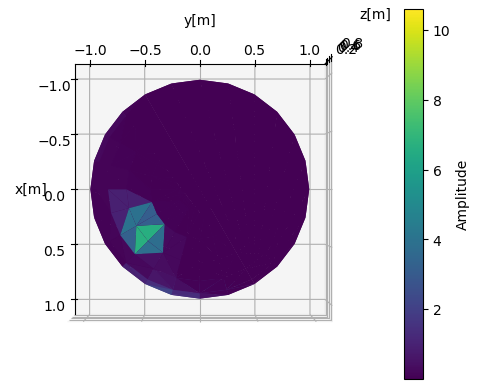

In [6]:
# use retroreflective scattering for the second simulation
BRDF_path = os.path.join(os.curdir, "brdf_walls_BSC.sofa")
sofa_data = sf.read_sofa(BRDF_path)
brdf_rr, brdf_sources_rr, brdf_receivers_rr = pf.io.convert_sofa(sofa_data)

brdf_sources_rr.weights = sofa_data.SourceWeights
brdf_receivers_rr.weights = sofa_data.ReceiverWeights

radiosity_retroreflection.set_wall_brdf(
    np.arange(len(boundaries)).tolist(),
    brdf_rr,
    brdf_sources_rr,
    brdf_receivers_rr,
)

# short data check
print("\nThe BRDF data contains", brdf_sources_rr.csize, "points.")

imag_array_where = np.iscomplex(brdf_rr.freq)
count_of_imag = np.count_nonzero(imag_array_where)
print("The BRDF data contains", count_of_imag, "datapoints with imag values.")

# plotting BRDF data
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(
    brdf_receivers_rr.x,
    brdf_receivers_rr.y,
    brdf_receivers_rr.z,
)
plt.show()

direction = 45
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
print(
    "BRDF from source pos:",
    brdf_receivers_rr.x[direction],
    "/",
    brdf_receivers_rr.y[direction],
    "/",
    brdf_receivers_rr.z[direction],
)
ind_max_reflection = np.argmax(brdf_rr.freq[direction, :, -1])
print(
    "BRDF maximum reflective coordinates:",
    brdf_receivers_rr.x[ind_max_reflection],
    "/",
    brdf_receivers_rr.y[ind_max_reflection],
    "/",
    brdf_receivers_rr.z[ind_max_reflection],
    "\n\n",
)
sph.plot.pcolor_sphere(
    brdf_receivers_rr,
    np.real(brdf_rr.freq[direction, :, -1]),
    ax=ax,
)
ax.view_init(elev=90, azim=0, roll=0)
plt.show()

To run the simulation, the energetic relationships of the different surface parts of the geometry are precomputed (baked) to enable energy exchange estimation between patches at a later stage.

In [7]:
radiosity_diffuse.bake_geometry()
radiosity_retroreflection.bake_geometry()

/home/ubunti/HiWi/sparrowpy/sparrowpy/classes/RadiosityFast.py:1348: ComplexWarning: Casting complex values to real discards the imaginary part
  form_factors_tilde[i, j, :, :] = form_factors_tilde[


Next, the distribution of the source's initial energy to each visible patch is simulated.

In [8]:
radiosity_diffuse.init_source_energy(source)
radiosity_retroreflection.init_source_energy(source)

Subsequently, the energy exchange between the patches is calculated.

In [9]:
radiosity_diffuse.calculate_energy_exchange(
    speed_of_sound=speed_of_sound,
    etc_time_resolution=etc_time_resolution,
    etc_duration=etc_duration,
    max_reflection_order=max_reflection_order,
)
radiosity_retroreflection.calculate_energy_exchange(
    speed_of_sound=speed_of_sound,
    etc_time_resolution=etc_time_resolution,
    etc_duration=etc_duration,
    max_reflection_order=max_reflection_order,
)

Finally, the energy is collected at the specified receiver point(s).

In [10]:
etc_diffuse = radiosity_diffuse.collect_energy_receiver_mono(
    receivers=receiver,
)
etc_retroreflection = radiosity_retroreflection.collect_energy_receiver_mono(
    receivers=receiver,
)

The two simulations can be visually compared.

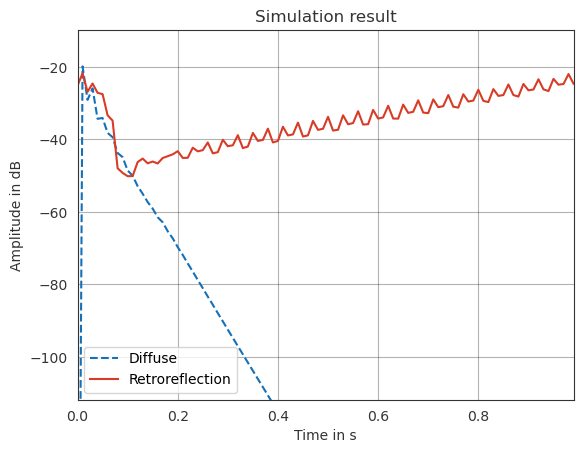

In [14]:
# plot the results separately for the frequency bands and the scattering types
plt.figure()
pf.plot.time(
    etc_diffuse,
    dB=True,
    log_prefix=10,
    label="Diffuse",
    linestyle="--",
)
pf.plot.time(
    etc_retroreflection[0, -1],  # plot only the highest frequency band (-1)
    dB=True,
    log_prefix=10,
    label="Retroreflection",
)
plt.title("Simulation result")
plt.legend()
plt.show()

In [12]:
%load_ext watermark
%watermark -v -m -iv

Python implementation: CPython
Python version       : 3.11.14
IPython version      : 9.1.0

Compiler    : GCC 14.3.0
OS          : Linux
Release     : 5.15.167.4-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
matplotlib: 3.10.7
spharpy   : 0.6.2
sofar     : 1.2.2
pyfar     : 0.7.3
sparrowpy : 1.0.0

